<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/13-transfer-learning/02_transfer_learning_with_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer learning with Text

The idea behind transfer learning is
that if someone has gone through the effort of training a big model on a bunch of data,
you can probably use that already trained model as a starting point for your problem.

Transfer learning works best when there are intrinsic similarities between the original
larger set of data and the smaller target data you want to apply it to.

Essentially, we want to transfer things we have learned
about one domain to a different, but related, domain. This is the idea behind transfer
learning.



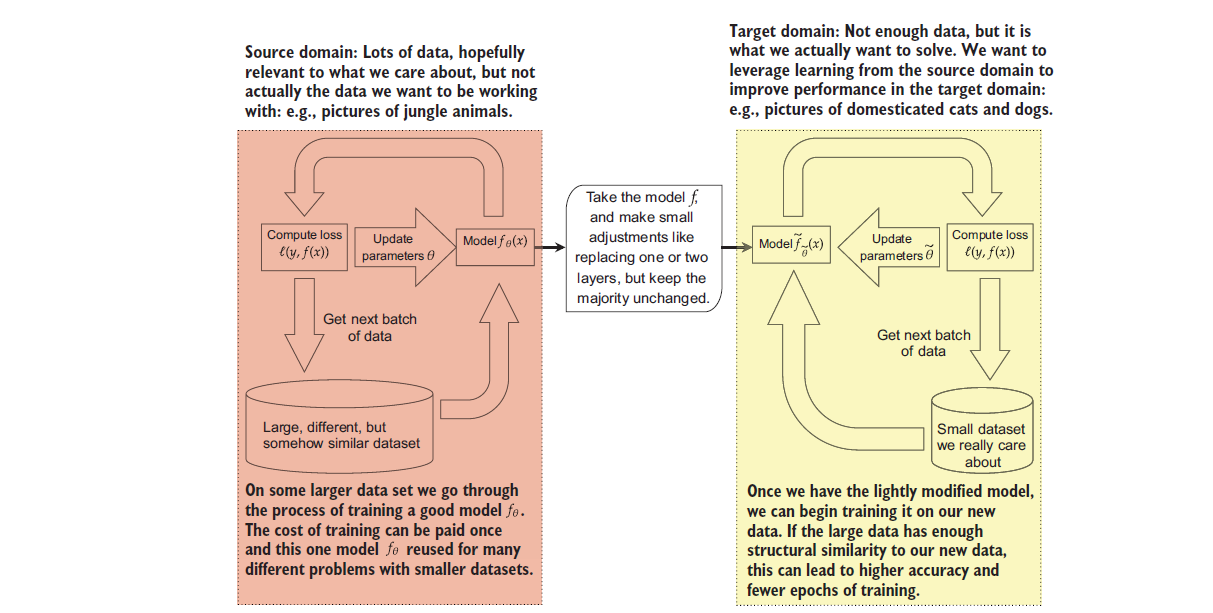

One of the most successful approaches to transfer learning that we learn to transfer the weights $w_{\theta}$ from one model to another. The original model is
trained on a large dataset of high-quality data, which shares some structural similarities
with the smaller set of data that we really care about.

The success of using pretrained networks to perform transfer learning depends on learning robust features/patterns that are widely applicable.

Until recently, this approach had not been successful for natural language processing (NLP) related tasks. Thanks to new models like the transformer, this situation is finally starting to change.

In particular, a family of transformer-based algorithms has significantly improved the quality of results we can achieve on text problems. The first of these pretrained models is called BERT.

To get started adjusting a pretrained BERT model, we will reuse the AG News dataset.

##Setup

In [ ]:
!pip install portalocker
!pip install transformers
!pip install sentencepiece

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.datasets import AG_NEWS
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer, DistilBertModel

from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

from idlmam import LastTimeStep, train_network, Flatten, weight_reset, View, LambdaLayer
from idlmam import AttentionAvg, GeneralScore, DotScore, AdditiveAttentionScore, getMaskByFill
from idlmam import set_seed

import time
import os
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from collections import Counter
import re

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [5]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
import warnings
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

In [8]:
!mkdir -p data

##AG News dataset

In [9]:
# let’s quickly load AG_NEWS dataset
train_iter, test_iter = AG_NEWS(root="./data", split=("train", "test"))

train_dataset = list(train_iter)
test_dataset = list(test_iter)

In [10]:
print(train_dataset[0])

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")


In [11]:
# tokenizers break strings like "this is a string" into lists of tokens like ['this', 'is', 'a', 'string']
tokenizer = get_tokenizer("basic_english") # we will be fine with the default english style tokenizer

# we need to create a vocabulary of all the words in the training set
counter = Counter()
for (label, line) in train_dataset:
  # count the number of unique tokens we see and how often we see them (e.g., we will see "the" a lot, but "sasquatch" maybe once or not at all.)
  counter.update(tokenizer(line))
# create a vocab object, removing any word that didn't occur at least 10 times,
# and add special vocab items for unkown, begining of sentance, end of sentance, and "padding"
vocab = vocab(counter, min_freq=10, specials=("<unk>", "<BOS>", "<EOS>", "<PAD>"))
vocab.set_default_index(vocab["<unk>"])

In [12]:
len(vocab)

20647

In [13]:
def text_transform(x):
  # vocab acts like a dictionary, handls unkown tokens.
  # We can make it pre- and post-pend with the start and end markers, respectively.
  return [vocab["<BOS>"]] + [vocab[token] for token in tokenizer(x)] + [vocab["<EOS>"]]

def label_transform(y):
  # labes are originally [1, 2, 3, 4] but we need them as [0, 1, 2, 3]
  return y - 1

def pad_batch(batch):
  """
  Pad items in the batch to the length of the longest item in the batch.
  Also, re-order so that the values are returned (input, label)
  """
  labels = [label_transform(z[0]) for z in batch]
  texts = [torch.tensor(text_transform(z[1]), dtype=torch.int64) for z in batch]

  max_len = max([text.size(0) for text in texts])

  PAD = padding_idx

  texts = [F.pad(text, (0,max_len-text.size(0)), value=PAD) for text in texts]

  x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)

  return x, y

In [14]:
train_dataset[0][1]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [15]:
# let's transform the first data point's text into a list of tokens
print(text_transform(train_dataset[0][1]))

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 14, 16, 0, 17, 4, 18, 19, 20, 0, 21, 0, 17, 22, 23, 24, 25, 6, 2]


In [16]:
# To make training faster, let’s limit ourselves to sentences that contain six or fewer words.
VOCAB_SIZE  = len(vocab)
NUM_CLASS = len(np.unique([z[0] for z in train_dataset]))
print(f"Vocab: {VOCAB_SIZE}")
print(f"Num Classes: {NUM_CLASS}")

padding_idx = VOCAB_SIZE
VOCAB_SIZE += 1

Vocab: 20647
Num Classes: 4


Learning with limited training data is where transfer learning gets the greatest
return on results and also helps these examples run quickly.

In [17]:
# let's create a small version of the corpus with 256 labeled items
train_data_text_small, _ = torch.utils.data.random_split(train_dataset, (256, len(train_dataset) - 256))

In [18]:
# Create train & test loader using this collate_fn
train_text_loader = DataLoader(train_data_text_small, batch_size=32, shuffle=True, collate_fn=pad_batch)
test_text_loader = DataLoader(test_dataset, batch_size=32, collate_fn=pad_batch)

##Baseline model

In [19]:
embed_dim = 128

gru = nn.Sequential(
  nn.Embedding(VOCAB_SIZE, embed_dim),  # (B, T) -> (B, T, D)
  nn.GRU(embed_dim, embed_dim, num_layers=3, batch_first=True, bidirectional=True), # (B, T, D) -> ((B,T,D) , (S, B, D))
  LastTimeStep(rnn_layers=3, bidirectional=True), # We need to take the RNN output and reduce it to one item, (B, 2*D)
  nn.Linear(embed_dim * 2, NUM_CLASS)  # (B, D) -> (B, classes)
)

In [ ]:
# Train our baseline GRU model
gru_results = train_network(gru,
                            nn.CrossEntropyLoss(),
                            train_text_loader,
                            val_loader=test_text_loader,
                            score_funcs={'Accuracy': accuracy_score},
                            device=device, epochs=10)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

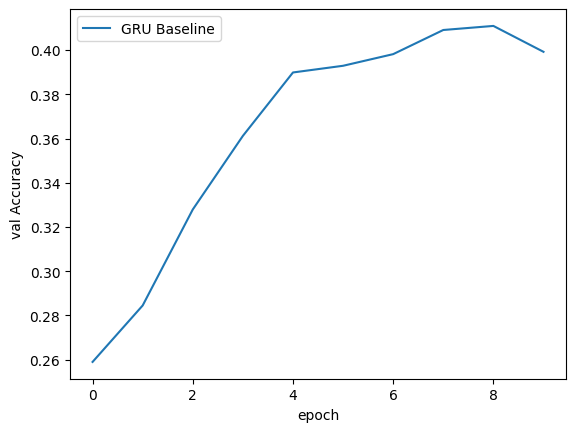

In [21]:
sns.lineplot(x="epoch", y="val Accuracy", data=gru_results, label="GRU Baseline")

On the full dataset, a GRU was able to obtain 92% accuracy. With this smaller labeled set, we expect the accuracy to decrease.

##Pretrained model

In [ ]:
# initialize the tokenizer (converts strings-> input tensors) and the model (input tensorts -> output tensors)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model  = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [23]:
def huggingface_batch(batch):
  """
  Pad items in the batch to the length of the longest item in the batch.
  Also, re-order so that the values are returned (input, label)
  """
  labels = [label_transform(z[0]) for z in batch] #these first three lines are the same as before
  texts = [z[1] for z in batch] #CHANGED: Don't use our old text_transform, just get the raw texts

  #New: Let huggingface encode a batch of strhings for us
  texts = tokenizer.batch_encode_plus(texts, return_tensors='pt', padding=True)['input_ids']

  #Now back to old code, stack them up and return the tensors
  x, y = texts, torch.tensor(labels, dtype=torch.int64)
  return x, y

In [24]:
# just making our data loaders with this new collage_fn
train_text_bert_loader = DataLoader(train_data_text_small, batch_size=32, shuffle=True, collate_fn=huggingface_batch)
test_text_bert_loader = DataLoader(test_dataset, batch_size=32, collate_fn=huggingface_batch)

In [25]:
class BertBasedClassifier(nn.Module):
  def __init__(self, bert_model, classes):
    """
    bert_model: the BERT based classification model to use as a forzen initial layer of the network
    classes: the number of output neurons / target classes for this classifier.
    """
    super(BertBasedClassifier, self).__init__()

    # We will get a tensort of (B, T, D) shape out from bert
    # So we will define a few of our own layers to get from (B, T, D) -> a prediction of shape (B, classes)
    self.bert_model = bert_model
    # Attention to get down to (B, D) shape
    self.attention = AttentionAvg(AdditiveAttentionScore(bert_model.config.dim))
    # Do a little feature extraction
    self.fc1 = nn.Linear(bert_model.config.dim, bert_model.config.dim)
    # Make a prediction about the class
    self.prediction = nn.Linear(bert_model.config.dim, classes)

  def forward(self, inputs):
    # Input is (B, T)
    mask = getMaskByFill(inputs)
    # This "with no_grad() does the freezing"
    with torch.no_grad():
      # huggingface returns a tuple, so unpack it!
      x = self.bert_model(inputs)[0] # (B, T, D)
    # Compute the average embedding
    context = x.sum(dim=1) / (mask.sum(dim=1).unsqueeze(1) + 1e-5)
    # apply attention
    x = self.attention(x, context, mask)
    # Make preditions and return
    x = F.relu(self.fc1(x))
    return self.prediction(x)

In [26]:
# Build the classifier!
bert_classifier = BertBasedClassifier(bert_model, NUM_CLASS)

In [ ]:
bert_results = train_network(bert_classifier,
                               nn.CrossEntropyLoss(),
                               train_text_bert_loader,
                               val_loader=test_text_bert_loader,
                               score_funcs={'Accuracy': accuracy_score},
                               device=device, epochs=10)

<Axes: xlabel='epoch', ylabel='val Accuracy'>

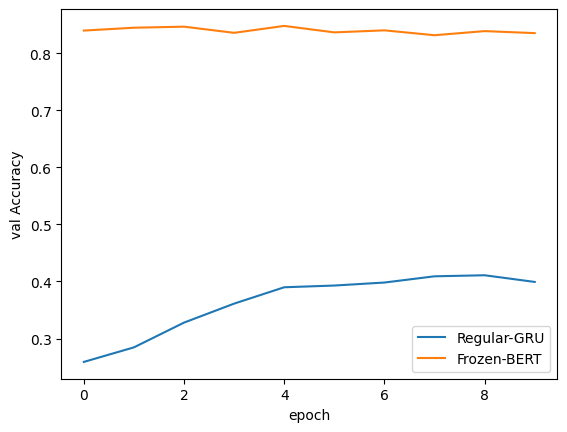

In [31]:
sns.lineplot(x="epoch", y="val Accuracy", data=gru_results, label="Regular-GRU")
sns.lineplot(x="epoch", y="val Accuracy", data=bert_results, label="Frozen-BERT")

Looking at the results, we can see that the GRU is learning, but very slowly.

Our frozen BERT model gets  `84%`, which is a significant improvement.

BERT-style models tend to be very large and thus computationally expensive. Training and applying our BERT classifier was about 10x slower than the GRU.